<a href="https://colab.research.google.com/github/AlejoBSmith/TensorflowMicrocontroller/blob/main/PrimerTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [68]:
#Programa para hacer un "Hola mundo" de redes neuronales usando Tensorflow
#Se va a generar una onda senoidal y se va a alimentar a una red neuronal para aprender la regresión
#El primer paso es la instalación de paquetes y dependencias

!pip install tensorflow==2.0 #El signo de admiración es necesario para que se instale en el sistema. NO es un comando para Jupyter, como el resto del programa de aquí en adelante
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt #pyplot son pa manejar las gráficas como en matlab
import math

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


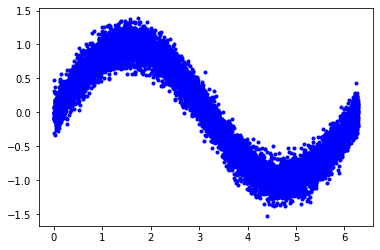

In [69]:
#Generar los datos de entrenamiento (onda senoidal)
SAMPLES=10000
x_values = np.random.uniform(low=0, high=2*math.pi, size=SAMPLES)
np.random.shuffle(x_values) #Pa desordenar el vector x
y_values = np.sin(x_values) #Se una el de la librería numpy porque la de math solo trabaja con un dato

#La vida no es perfecta, siempre hay ruido en las mediciones
y_values += 0.15*np.random.randn(SAMPLES) #Primero determina de qué tamaño es el array, luego le suma los números

#Graficar pa ve cómo quedó
plt.plot(x_values, y_values, 'b.')
plt.show()

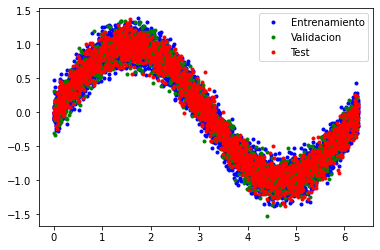

In [70]:
#Como se va a entrenar una red neuronal, hay que tener subset de entrenamiento (60%), validación (20%) y test (20%)
#El método .split corta un array en la posición que se le indica y regresa los pedazos
XEntrenamiento, XValidacion, XTest = np.split(x_values,[int(0.6*SAMPLES), int(0.8*SAMPLES)])
YEntrenamiento, YValidacion, YTest = np.split(y_values,[int(0.6*SAMPLES), int(0.8*SAMPLES)])

#Graficar los subsets pa ve
plt.plot(XEntrenamiento, YEntrenamiento, 'b.', label="Entrenamiento")
plt.plot(XValidacion, YValidacion, 'g.', label="Validacion")
plt.plot(XTest, YTest, 'r.', label="Test")
plt.legend()
plt.show()

In [71]:
#Ahora hay que definir la red neuronal
from tensorflow import keras
from tensorflow.keras import layers

model_1 = tf.keras.Sequential() #El modelo secuencial es SISO
model_1.add(layers.Dense(16, activation='sigmoid', input_shape=(1,))) #Capa intermedia, 16 neuronas, 1 entrada, ReLU
model_1.add(layers.Dense(1)) #La capa de salida
model_1.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
model_1.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 16)                32        
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 17        
Total params: 49
Trainable params: 49
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Definir los parámetros de entrenamiento
InfoEntrenamiento = model_1.fit(XEntrenamiento, YEntrenamiento, batch_size=16, epochs=500, validation_data=(XValidacion, YValidacion))

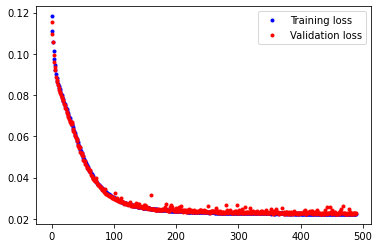

In [73]:
#Visualizar los resultados del entrenamiento
loss=InfoEntrenamiento.history['loss']
mae=InfoEntrenamiento.history['mae']
lossValidacion=InfoEntrenamiento.history['val_loss']
maeValidacion=InfoEntrenamiento.history['val_mae']
SKIP=10

plt.plot(loss[SKIP:], 'b.', label="Training loss")
plt.plot(lossValidacion[SKIP:], 'r.', label="Validation loss")
plt.legend()
plt.show()

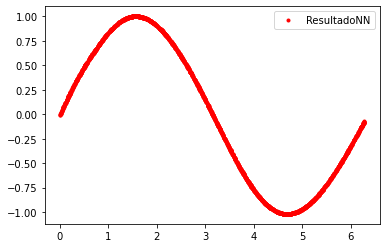

In [74]:
#Realizar predicciones con el modelo obtenido pa ve como sale
predicciones = model_1.predict(XTest)

plt.clf() #Borra la figura que ta en la memoria
plt.plot(XTest, predicciones, 'r.', label="ResultadoNN")
plt.legend()
plt.show()

In [79]:
#Ahora hay que convertir el modelo (que se supone se hizo para una PC poderosa) a un modelo de menos resolución (microcontrolador)
converter = tf.lite.TFLiteConverter.from_keras_model(model_1)
converter.optimizations=[tf.lite.Optimize.DEFAULT] #Se puede optimizar para latencia o memoria. Se deja en default

#Generador para los datos de testeo (Generador es un tipo especial de ciclo de python, si quieren entender, googleen python generators)
def generator():
  for dato in XTest:
    yield[np.array(dato, dtype=np.float32, ndmin=2)]
converter.representative_dataset = generator
tflite_model = converter.convert()

open("sine_quantized.tflite", "wb").write(tflite_model)

1872

In [80]:
#Ahora hay que usar xxd (Unix) para convertir el archivo a C
#Si xxd no está instalado, que se instale pej
!apt-get -qq install xxd
!xxd -i sine_quantized.tflite > sine_quantized.cc
!cat sine_quantized.cc #ESTO es lo que nos interesa

Selecting previously unselected package xxd.
(Reading database ... 155639 files and directories currently installed.)
Preparing to unpack .../xxd_2%3a8.0.1453-1ubuntu1.8_amd64.deb ...
Unpacking xxd (2:8.0.1453-1ubuntu1.8) ...
Setting up xxd (2:8.0.1453-1ubuntu1.8) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
unsigned char sine_quantized_tflite[] = {
  0x20, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x00, 0x00, 0x00, 0x00,
  0x00, 0x00, 0x12, 0x00, 0x1c, 0x00, 0x04, 0x00, 0x08, 0x00, 0x0c, 0x00,
  0x10, 0x00, 0x14, 0x00, 0x00, 0x00, 0x18, 0x00, 0x12, 0x00, 0x00, 0x00,
  0x03, 0x00, 0x00, 0x00, 0xcc, 0x06, 0x00, 0x00, 0x4c, 0x01, 0x00, 0x00,
  0x34, 0x01, 0x00, 0x00, 0x3c, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00,
  0x01, 0x00, 0x00, 0x00, 0x0c, 0x00, 0x00, 0x00, 0x08, 0x00, 0x0c, 0x00,
  0x04, 0x00, 0x08, 0x00, 0x08, 0x00, 0x00, 0x00, 0x08, 0x00, 0x00, 0x00,
  0x09, 0x00, 0x00, 0x00, 0x13, 0x00, 0x00, 0x00, 0x6d, 0x69, 0x6e, 0x5f,
  0x72, 0x75, 0x6e, 0x74, 0x69, 0x6d, 0x65,